In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d harishprabhu/glucoma-oct-images

Dataset URL: https://www.kaggle.com/datasets/harishprabhu/glucoma-oct-images
License(s): apache-2.0
 74% 17.0M/22.9M [00:00<00:00, 44.0MB/s]
100% 22.9M/22.9M [00:00<00:00, 50.8MB/s]


In [ ]:
!unzip glucoma-oct-images.zip -d ./glucoma-oct-images

Archive:  glucoma-oct-images.zip
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG1.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG10.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG100.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG101.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG102.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG103.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG104.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG105.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG106.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG107.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG108.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG109.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG11.jpg  
  inflating: ./glucoma-oct-images/acrima/advance_glaucoma/AG1

In [ ]:
# Importing necessary libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def load_from_directory(data_dir):

    images = []
    labels = []

    # Loop through each folder in the dataset directory
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        # Loop through each image in the folder
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)

            # Read the image using OpenCV
            img = cv2.imread(img_path)

            # Check if image are valid or not
            if img is not None:

                # Convertion from BGR to GrayScale, RGB
#                 img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Resize the image to target size (224, 224)
                img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

                # Append to the empty list
                images.append(img)
                labels.append(folder_name)

            else:
                print(f"Invalid image exists: {img_path}")

    return images, labels


# Data Directories:
data_dir = '/content/glucoma-oct-images/acrima'
images, labels = load_from_directory(data_dir)

# Images to Array
images = np.array(images)
labels = np.array(labels)

# display Dimensions
print(images.shape)
print(labels.shape)

(706, 224, 224, 3)
(706,)


In [ ]:
# Splitting Normal and Advanced Glaucoma Images
normal_glaucoma = images[labels == 'normal_glaucoma']
advance_glaucoma = images[labels == 'advance_glaucoma']

# Display Dimensions
print(f'Dimension of Normal Glaucoma data: {normal_glaucoma.shape}')
print(f'Dimension of Advance Glaucoma data: {advance_glaucoma.shape}')

Dimension of Normal Glaucoma data: (309, 224, 224, 3)
Dimension of Advance Glaucoma data: (397, 224, 224, 3)


In [ ]:
def plot_random_images(data, label):
    f, ax = plt.subplots(5, 5)
    f.subplots_adjust(0,0,3,3)

    for i in range(0,5,1):
        for j in range(0,5,1):
            rnd_num = randint(0, len(data))
            ax[i, j].imshow(data[rnd_num])
            ax[i, j].set_title(label[rnd_num])
            ax[i, j].axis('off')

plot_random_images(images, labels)

This cell output is too large and can only be displayed while logged in.


In [ ]:
def preprocess_and_enhance_images(images):
    processed_images = []

    for image in images:
        # Noise Reduction
        blurred_image = cv2.GaussianBlur(image, (3, 3), 0)

        # Edge Detection (Canny)
        edges = cv2.Canny(image, 50, 100)

        # Sharpening (Unsharp Masking)
        unsharp_image = cv2.addWeighted(image, 1.0, blurred_image, -0.5, 0)

        processed_images.append(unsharp_image)

    # Convert the list of processed images to an array
    processed_images_array = np.array(processed_images)

    return processed_images_array

images = preprocess_and_enhance_images(images)
plot_random_images(images, labels)

This cell output is too large and can only be displayed while logged in.


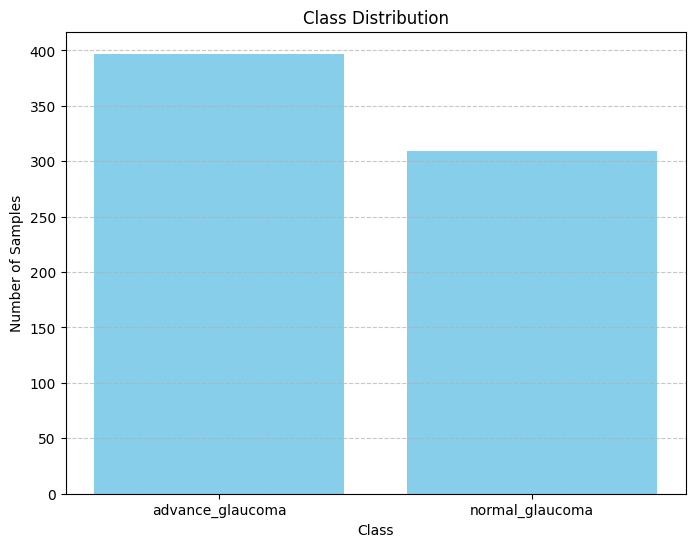

'The dataset is balanced.'

In [ ]:
def data_imbalance_check(label):
    # Count the number of samples for each class
    unique_labels, class_counts = np.unique(label, return_counts=True)

    # Plot the class distribution
    plt.figure(figsize=(8, 6))
    plt.bar(unique_labels, class_counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(unique_labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Check for class imbalance
    if len(unique_labels) < 2 or np.min(class_counts) / np.max(class_counts) < 0.5:
        return "The dataset is imbalanced."
    else:
        return "The dataset is balanced."

data_imbalance_check(labels)

In [ ]:
train_images = images / 255
print(train_images.shape)

(706, 224, 224, 3)


In [ ]:
train_labels = np.array([0 if labels == 'normal_glaucoma' else 1 for labels in labels])
print(train_labels.shape)

(706,)


In [ ]:
classes = np.unique(labels)
classes

array(['advance_glaucoma', 'normal_glaucoma'], dtype='<U16')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_images, train_labels, test_size = 0.3, random_state = 42)

# Display Dimensions
print(f'X_train: {x_train.shape}')
print(f'X_test: {x_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (494, 224, 224, 3)
X_test: (212, 224, 224, 3)
y_train: (494,)
y_test: (212,)


In [ ]:
#print(x_train[10].shape)

# Setting value of K (Number of classes to classify)
k = len(set(train_labels))
print(k)

2


In [ ]:
i = Input(shape = x_train[0].shape)

x = Conv2D(64, (3,3), strides = 2, activation = 'relu')(i)
x = Dropout(0.2)(x)
x = Conv2D(64, (3,3), strides = 2, activation = 'relu')(x)
x = MaxPooling2D((2,2))(x)

# x = Dropout(0.2)(x)
x = MaxPooling2D((3,3))(x)

x = Conv2D(64, (3,3), strides = 2, activation = 'relu')(x)
x = Dropout(0.25)(x)
x = MaxPooling2D((3,3))(x)

x = Flatten()(x)

x = Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.02))(x)
x = Dropout(0.5)(x)
x = Dense(k, activation = 'softmax')(x)

model = Model(i, x)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 111, 111, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 55, 55, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,226 (329.01 KB)

 Trainable params: 84,226 (329.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train , validation_data = (x_test, y_test), epochs = 100,  batch_size = 60, callbacks = [early_stopping])

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9228 - loss: 0.2530 - val_accuracy: 0.9151 - val_loss: 0.2881
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9190 - loss: 0.2478 - val_accuracy: 0.9481 - val_loss: 0.2313
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9420 - loss: 0.2277 - val_accuracy: 0.9340 - val_loss: 0.2385
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9502 - loss: 0.2013 - val_accuracy: 0.8396 - val_loss: 0.3715
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8984 - loss: 0.2795 - val_accuracy: 0.9009 - val_loss: 0.3038


In [ ]:
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.9273 - loss: 0.2552
Validation Loss: 0.2312634140253067
Validation Accuracy: 0.948113203048706


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step


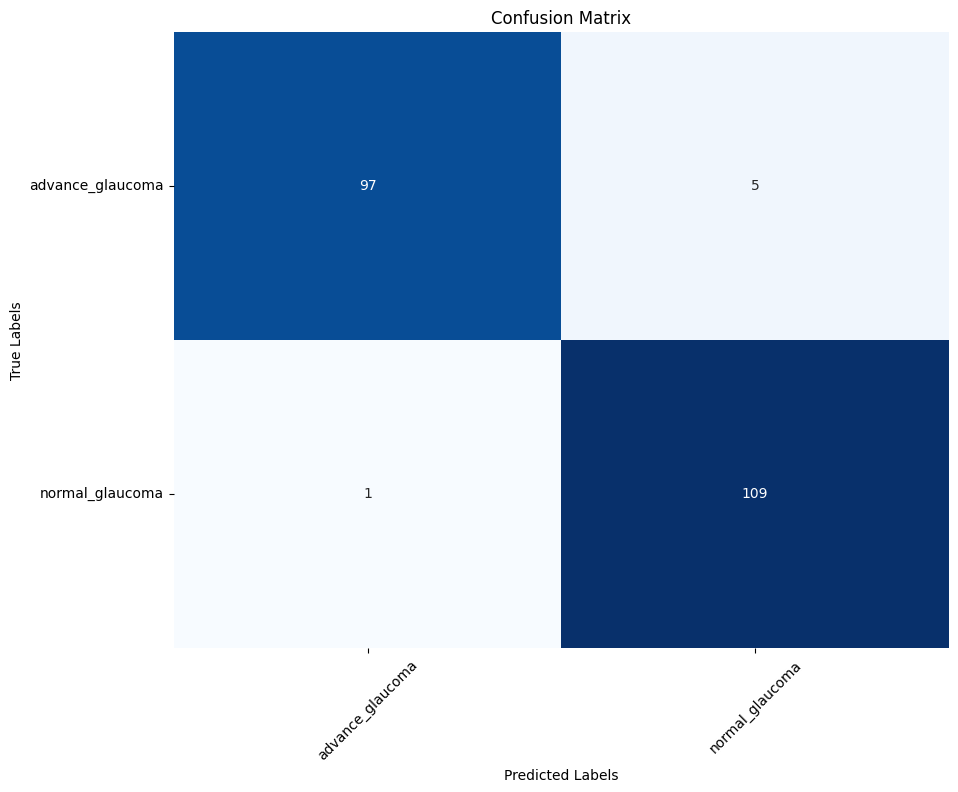

In [ ]:
y_pred_classes = np.argmax(model.predict(x_test), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels = classes, yticklabels = classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

# For AUC-ROC, you need predicted probabilities instead of classes
y_pred_prob = model.predict(x_test)  # Get predicted probabilities
y_pred_prob_positive_class = y_pred_prob[:, 1]  # Probability of positive class (assuming it's at index 1)

auc_roc = roc_auc_score(y_test, y_pred_prob_positive_class)


# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 810ms/step
Accuracy: 0.9717
Precision: 0.9561
Recall: 0.9909
F1-score: 0.9732
AUC-ROC: 0.9987


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step


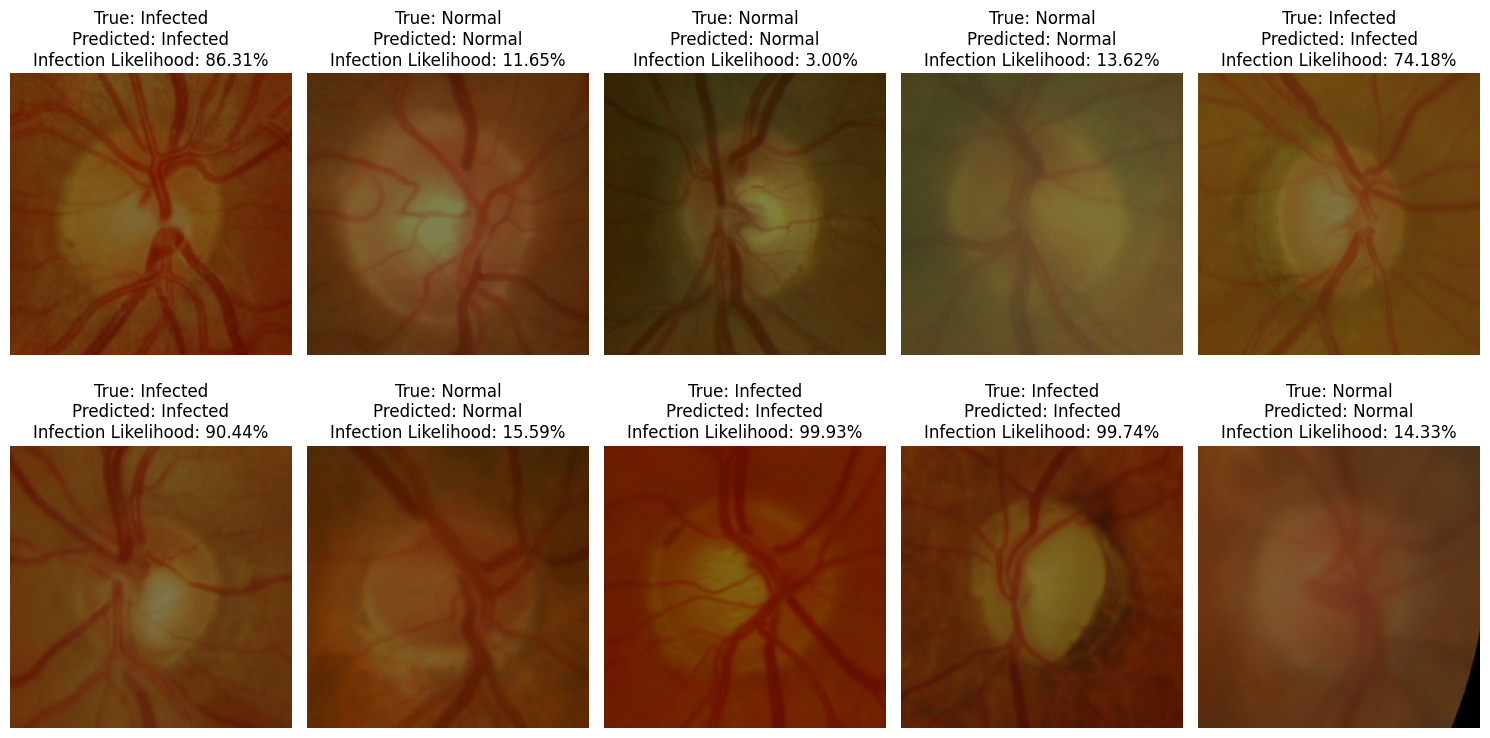

In [ ]:
# Predict labels for x_test
y_pred_prob = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Display images along with true and predicted labels
num_images_to_display = 10  # Number of images to display
plt.figure(figsize=(15, 8))

for i in range(num_images_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])  # Display image
    plt.axis('off')
    true_label = "Normal" if y_test[i] == 0 else "Infected"  # Assuming 0 represents "Normal" and 1 represents "Infected"
    predicted_label = "Normal" if y_pred_classes[i] == 0 else "Infected"
    infection_likelihood = y_pred_prob[i][1] * 100  # Probability of being infected in percentage
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nInfection Likelihood: {infection_likelihood:.2f}%')

plt.tight_layout()
plt.show()